# Práctica de Deep Learning 101
### *Alumno: David Jiménez Vicente*

---

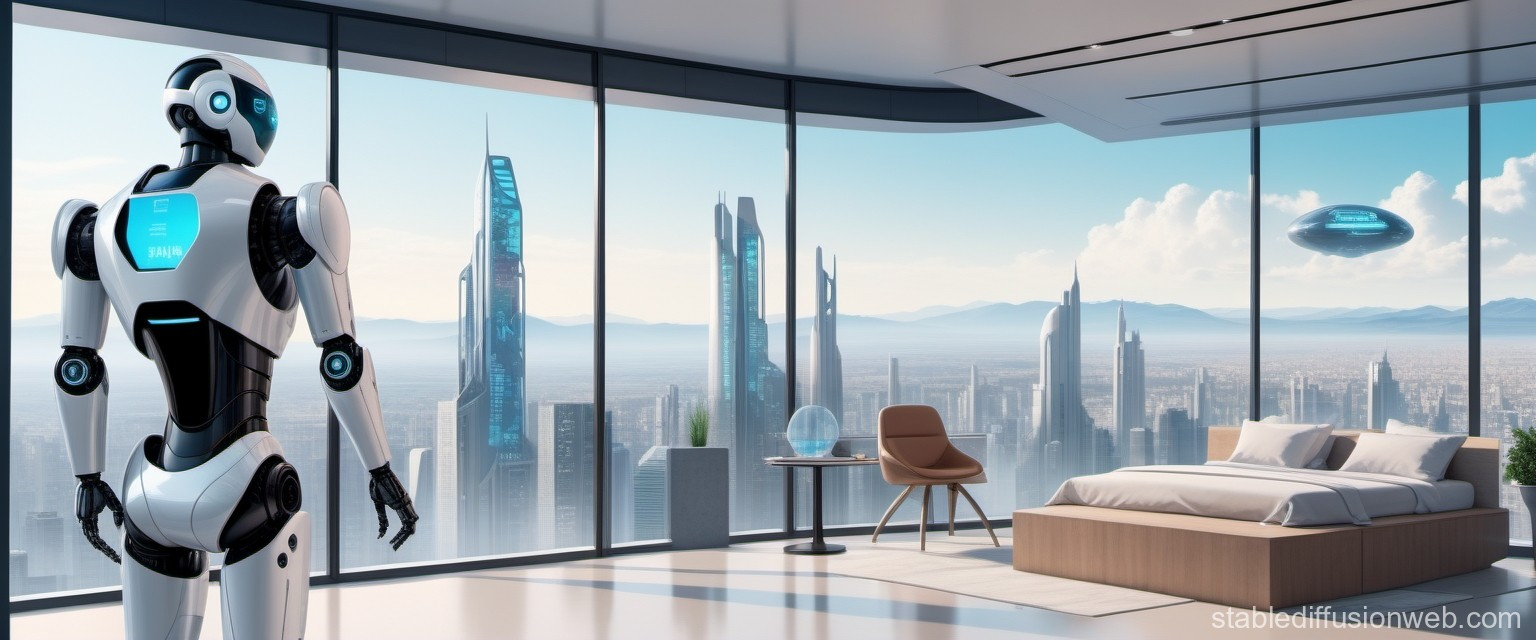

#### El objetivo de la práctica final del módulo de Deep Learning consiste en solucionar un problema del mundo real usando las técnicas vistas en clase. En concreto, lo que se pretende es tratar de predecir el precio de habitaciones de AirBnb utilizando para ello todas las características disponibles en el dataset.

#### Se pide concretamente fusionar en un único modelo dos modelos previos, uno para predecir en base imágenes y otro en base a datos tabulares. Este modelo final predecirá el resultado final en base a los cálculos previos de las dos redes anteriores.

---

---

<h2 align=center>ETAPA 1: CARGA Y PREPROCESADO DE LOS DATOS</h2>

## 1.- Importación de datos

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import cv2
import imageio.v3 as io
from tqdm import tqdm
from typing import Optional, Union

In [2]:
url="https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"
df = pd.read_csv(url, sep=";")

In [3]:
df.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,16536728,https://www.airbnb.com/rooms/16536728,20170407214119,2017-04-08,Ático en el Barrio de Salamanca,Precioso ático en el barrio de Salamanca. Dos...,NaN,Precioso ático en el barrio de Salamanca. Dos...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,moderate,1,NaN,"40.43007580267911,-3.674373225929859","Host Has Profile Pic,Is Location Exact,Require..."
1,14800288,https://www.airbnb.com/rooms/14800288,20170407214119,2017-04-08,"Salamanca Comfort XI, Friendly Rentals","Lugares de interés: Fide, Bienmesabe, Restaura...",Apartamento de nueva construcción (julio 2016)...,Apartamento de nueva construcción (julio 2016)...,none,"Localizado en el distrito de Salamanca, uno de...",...,8.0,10.0,9.0,NaN,NaN,strict,145,0.79,"40.43561324649597,-3.678321445006713","Host Has Profile Pic,Is Location Exact,Require..."
2,12357427,https://www.airbnb.com/rooms/12357427,20170407214119,2017-04-08,Apt. by the music Conservatory!!,Very bright apartment with 2 bedrooms 1 with p...,NaN,Very bright apartment with 2 bedrooms 1 with p...,none,NaN,...,8.0,8.0,8.0,NaN,NaN,flexible,1,0.43,"40.446440723481764,-3.6742595345116214","Host Has Profile Pic,Host Identity Verified,Is..."
3,7984552,https://www.airbnb.com/rooms/7984552,20170407214119,2017-04-08,Double Room near RealMadrid Stadium,The flat is on the ground floor. There's a com...,Cosy large room for two people with a flat TV ...,The flat is on the ground floor. There's a com...,none,Chamartín is an administrative district of Mad...,...,NaN,NaN,NaN,NaN,NaN,moderate,2,NaN,"40.455167347211834,-3.698099022915008","Host Is Superhost,Host Has Profile Pic,Is Loca..."
4,17244421,https://www.airbnb.com/rooms/17244421,20170407214119,2017-04-08,Mid Century Flat,Mi alojamiento es bueno para viajeros de negoc...,NaN,Mi alojamiento es bueno para viajeros de negoc...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1,NaN,"40.43988285945364,-3.71737227282086","Host Has Profile Pic,Is Location Exact,Require..."


## 2.- EDA y Preproc

*Realizaré el EDA y el Preproc antes de hacer la división de los datos entre Train y Test, sin contaminar el entrenamiento, para que ambos datasets tengan estructuras similares. Las mismas directrices de Preprocesado, Selección de características y Transformación, así como Nuevas características se aplicarán a los datos nuevos una vez en producción.*

Todo Preproc que, para crear nuevas features o modificar los valores reales, no use una combinación de los valores reales de las observaciones no contaminará los resultados de test. Operaciones como One Hot Encoding en base a categorías existentes, o a intervalos de valores cerrados no calculados en base a los valores presentes, no pueden contaminar los datos de train aunque se realize antes del split, ya que si una observación es de una clase, seguirá siendo de esa clase hayan estado los datos de test presentes o no, ya que no dependen de la interacción entre los valores medidos en el dataset.  
En cambio, operaciones como One Hot en base a N divisiones entre el mínimo y el máximo presente, o normalizaciones, o imputación de NaNs usando medias, etc... han de realizarse tras el split, ya que sí dependen de la interacción entre los valores reales del dataset.

In [4]:
# Veamos qué campos tiene el dataset:
df.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [5]:
# Con el parámetro include="all", .describe() también dará info acerca de las variables categóricas:
df.describe(include="all")

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
count,1.400100e+04,14001,1.400100e+04,14001,14001,13451,10306,13995,14001,8630,...,10848.000000,10830.000000,10828.000000,333,0.0,14001,14001.000000,10994.000000,14001,14001
unique,NaN,14001,NaN,2,13600,12565,9601,13510,1,7438,...,NaN,NaN,NaN,314,NaN,5,NaN,NaN,14001,60
top,NaN,https://www.airbnb.com/rooms/16536728,NaN,2017-04-08,Apartamento en el centro de Madrid,"Unique apartment in vibrant neighborhoods, car...",Los Apartamentos Good Stay Prado se encuentran...,Es un piso con 6 habitaciones de las que 5 ha...,none,Se trata de una de las zonas más emblemáticas ...,...,NaN,NaN,NaN,HUTB-009034,NaN,strict,NaN,NaN,"40.43007580267911,-3.674373225929859","Host Has Profile Pic,Host Identity Verified,Is..."
freq,NaN,1,NaN,13625,12,64,29,19,14001,32,...,NaN,NaN,NaN,5,NaN,5474,NaN,NaN,1,2498
mean,1.034537e+07,NaN,2.017040e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.640395,9.532872,9.207702,NaN,NaN,NaN,9.829298,1.881707,NaN,NaN
std,5.557061e+06,NaN,1.489419e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.771973,0.777239,0.957385,NaN,NaN,NaN,24.196777,1.871766,NaN,NaN
min,1.862800e+04,NaN,2.017032e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,2.000000,2.000000,NaN,NaN,NaN,1.000000,0.020000,NaN,NaN
25%,5.639157e+06,NaN,2.017041e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.000000,9.000000,9.000000,NaN,NaN,NaN,1.000000,0.460000,NaN,NaN
50%,1.146724e+07,NaN,2.017041e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,10.000000,9.000000,NaN,NaN,NaN,2.000000,1.220000,NaN,NaN
75%,1.536912e+07,NaN,2.017041e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,10.000000,10.000000,NaN,NaN,NaN,5.000000,2.810000,NaN,NaN


*· Tiene demasiadas características para poder extraer información rápidamente. Se necesita hacer una primera selección de características.*  
· Empezaré por comprobar las ciudades presentes en el dataset:

In [6]:
# Buscaremos los valores únicos en el campo "City"
df.City.sort_values().unique()

array(['Alaró', 'Alcudia', 'Alcúdia', 'Algaida', 'Andratx', 'Aravaca',
       'Aravaca (Madrid)', 'Ariany', 'Balearic Islands', 'Barcelona',
       'Betlem', 'Biniamar', 'Binissalem', 'Binissalem-Mallorca DO',
       'Boadilla del Monte', 'Bunyola', 'Búger', 'Caimari', 'Cala Agulla',
       'Cala Anguila-Cala Mendia', 'Cala Ferrera', 'Cala Magrana',
       'Cala Murada', 'Cala Pi', 'Cala Ratjada', 'Cala Santanyí',
       'Calvià', 'Campanet', 'Campos', 'Can Pastilla', 'Can Picafort',
       'Centro', 'Centro, Madrid', 'Chiva', 'Chueca', 'Chueca, Madrid',
       'Colonia Sant Pere', 'Colonia de Sant Pere',
       'Colònia de Sant Jordi', 'Comunidad de Madrid', 'Costa dels Pins',
       'Costitx', 'Deià', 'Delicias', 'Delicias-Madrid', 'Deyá',
       'El Toro', 'Felanitx', 'Font de Sa Cala',
       'Hospitalet de Llobregat', 'Illes Balears', 'Illetes', 'Inca',
       'La Elipa', 'La Puebla', 'Lloret de Vistalegre', 'Lloseta',
       'Llubí', 'Llucalcari', 'Llucmajor', 'MADRID', 'Madid', 

In [7]:
df.City.value_counts()

City
Madrid                 13207
Barcelona                292
马德里                       52
Palma                     49
Alcúdia                   40
                       ...  
El Toro                    1
Aravaca (Madrid)           1
Sa Coma                    1
Comunidad de Madrid        1
Cala Murada                1
Name: count, Length: 135, dtype: int64

Claramente, las categorías de City están muy desbalanceadas. Sólo usaré Madrid para que el modelo sea representativo.  
Además, aparecen varias maneras de referirse a Madrid, pero todas parecen contener los caracteres "mad".  
También hay barrios de Madrid inscritos en el campo Ciudad. Haré un primer filtrado con eso.

In [8]:
# Seleccionamos por los caracteres "mad" o las locvalizaciones que pertenecen a Madrid erróneamente clasificadas. Esto debería evitarse en el frontend en producción.
df_madrid = df[df.City.str.contains("Mad") | df.City.str.contains("mad") | df.City.str.contains("MAD") | df.City.str.contains("Aravaca") | df.City.str.contains("villa verde bajo") | df.City.str.contains("Chueca") | df.City.str.contains("Ventas") | df.City.str.contains("Boadilla") | df.City.str.contains("Elipa") | df.City.str.contains("Pozuelo") | df.City.str.contains("de Henares") | df.City.str.contains("Delicias")]
df_madrid.City.sort_values().unique()

array(['Aravaca', 'Aravaca (Madrid)', 'Boadilla del Monte',
       'Centro, Madrid', 'Chueca', 'Chueca, Madrid',
       'Comunidad de Madrid', 'Delicias', 'Delicias-Madrid', 'La Elipa',
       'MADRID', 'Madid', 'Madri', 'Madrid',
       'Madrid, Comunidad de Madrid, ES',
       'Madrid, Comunidad de Madrid, ESPANA',
       'Madrid, Vallecas (Fontarrón)', 'Pozuelo', 'Pozuelo de Alarcón',
       'San Fernando de Henares', 'Ventas', 'las matas  madrid', 'madrid',
       'villa verde bajo'], dtype=object)

In [9]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13263 entries, 0 to 13999
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              13263 non-null  int64  
 1   Listing Url                     13263 non-null  object 
 2   Scrape ID                       13263 non-null  int64  
 3   Last Scraped                    13263 non-null  object 
 4   Name                            13263 non-null  object 
 5   Summary                         12775 non-null  object 
 6   Space                           9684 non-null   object 
 7   Description                     13257 non-null  object 
 8   Experiences Offered             13263 non-null  object 
 9   Neighborhood Overview           8304 non-null   object 
 10  Notes                           5032 non-null   object 
 11  Transit                         8257 non-null   object 
 12  Access                          7541 

Ahora eliminaré la columna "City", ya que ya no es necesaria, junto con otras:

Eliminaremos características con poca relación con las caraterísticas del piso, como features que sólo son datos de registro o tracking de los scraps, y también variables de texto subjetivo como las descripciones del propietario sobre el piso, vecindario, ciudad, etc.... que no comparten valores comunes entre los registros. Así mismo, muchas variables de localización son redundantes. Eliminaré también aquellas con alto número de NaNs o que sean redundantes por referisrse al mismo tipo de variable.

In [10]:
df_madrid = df_madrid[["Thumbnail Url", "Host Total Listings Count", "Neighbourhood Group Cleansed", "Property Type", "Room Type", "Accommodates", "Bathrooms", "Beds", "Bedrooms", "Amenities", "Security Deposit", "Cleaning Fee", "Guests Included"
                 ,"Extra People", "Minimum Nights", "Maximum Nights", "Availability 30", "Number of Reviews", "Cancellation Policy", "Price"]]

In [11]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13263 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10778 non-null  object 
 1   Host Total Listings Count     13260 non-null  float64
 2   Neighbourhood Group Cleansed  13263 non-null  object 
 3   Property Type                 13263 non-null  object 
 4   Room Type                     13263 non-null  object 
 5   Accommodates                  13263 non-null  int64  
 6   Bathrooms                     13214 non-null  float64
 7   Beds                          13214 non-null  float64
 8   Bedrooms                      13240 non-null  float64
 9   Amenities                     13154 non-null  object 
 10  Security Deposit              5645 non-null   float64
 11  Cleaning Fee                  7845 non-null   float64
 12  Guests Included               13263 non-null  int64  
 13  Extra 

Usando el conocimiento del dominio, sabemos que hay dos variables que sus valores NaN son realmente valor 0: "Security Deposit" y "Cleaning Fee" son dos tasas que el cliente ha de activar proactivamente si las quiere cobrar, por lo que aceptamos correcto asumir que si no lo marcan es que el precio de esas dos tasas es 0, ya que no lo quiere cobrar. Por lo tanto, en estas dos sustituiremos los NaN por 0, y lo haré antes del split ya que la imputación no tiene que ver con el resto de los valores presentes en el dataset, si no que depende de la propia naturaleza de la variable:

In [12]:
df_madrid["Cleaning Fee"] = df_madrid["Cleaning Fee"].fillna(0)
df_madrid["Security Deposit"] = df_madrid["Security Deposit"].fillna(0)
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13263 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10778 non-null  object 
 1   Host Total Listings Count     13260 non-null  float64
 2   Neighbourhood Group Cleansed  13263 non-null  object 
 3   Property Type                 13263 non-null  object 
 4   Room Type                     13263 non-null  object 
 5   Accommodates                  13263 non-null  int64  
 6   Bathrooms                     13214 non-null  float64
 7   Beds                          13214 non-null  float64
 8   Bedrooms                      13240 non-null  float64
 9   Amenities                     13154 non-null  object 
 10  Security Deposit              13263 non-null  float64
 11  Cleaning Fee                  13263 non-null  float64
 12  Guests Included               13263 non-null  int64  
 13  Extra 

Empezando por los NaNs, nos quedan pocas variables con muy pocos NaNs, así que eliminaré esos registros, que son un pequeño porcentaje.

In [13]:
# Empezaré eliminando las filas de la que tiene más, a ver si elimina los NaNs de otras variables:
df_madrid = df_madrid[df_madrid["Amenities"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13154 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10704 non-null  object 
 1   Host Total Listings Count     13151 non-null  float64
 2   Neighbourhood Group Cleansed  13154 non-null  object 
 3   Property Type                 13154 non-null  object 
 4   Room Type                     13154 non-null  object 
 5   Accommodates                  13154 non-null  int64  
 6   Bathrooms                     13128 non-null  float64
 7   Beds                          13124 non-null  float64
 8   Bedrooms                      13131 non-null  float64
 9   Amenities                     13154 non-null  object 
 10  Security Deposit              13154 non-null  float64
 11  Cleaning Fee                  13154 non-null  float64
 12  Guests Included               13154 non-null  int64  
 13  Extra 

In [14]:
df_madrid = df_madrid[df_madrid["Host Total Listings Count"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13151 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10701 non-null  object 
 1   Host Total Listings Count     13151 non-null  float64
 2   Neighbourhood Group Cleansed  13151 non-null  object 
 3   Property Type                 13151 non-null  object 
 4   Room Type                     13151 non-null  object 
 5   Accommodates                  13151 non-null  int64  
 6   Bathrooms                     13125 non-null  float64
 7   Beds                          13121 non-null  float64
 8   Bedrooms                      13128 non-null  float64
 9   Amenities                     13151 non-null  object 
 10  Security Deposit              13151 non-null  float64
 11  Cleaning Fee                  13151 non-null  float64
 12  Guests Included               13151 non-null  int64  
 13  Extra 

In [15]:
df_madrid = df_madrid[df_madrid["Beds"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13121 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10676 non-null  object 
 1   Host Total Listings Count     13121 non-null  float64
 2   Neighbourhood Group Cleansed  13121 non-null  object 
 3   Property Type                 13121 non-null  object 
 4   Room Type                     13121 non-null  object 
 5   Accommodates                  13121 non-null  int64  
 6   Bathrooms                     13100 non-null  float64
 7   Beds                          13121 non-null  float64
 8   Bedrooms                      13111 non-null  float64
 9   Amenities                     13121 non-null  object 
 10  Security Deposit              13121 non-null  float64
 11  Cleaning Fee                  13121 non-null  float64
 12  Guests Included               13121 non-null  int64  
 13  Extra 

In [16]:
df_madrid = df_madrid[df_madrid["Price"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13114 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10674 non-null  object 
 1   Host Total Listings Count     13114 non-null  float64
 2   Neighbourhood Group Cleansed  13114 non-null  object 
 3   Property Type                 13114 non-null  object 
 4   Room Type                     13114 non-null  object 
 5   Accommodates                  13114 non-null  int64  
 6   Bathrooms                     13093 non-null  float64
 7   Beds                          13114 non-null  float64
 8   Bedrooms                      13104 non-null  float64
 9   Amenities                     13114 non-null  object 
 10  Security Deposit              13114 non-null  float64
 11  Cleaning Fee                  13114 non-null  float64
 12  Guests Included               13114 non-null  int64  
 13  Extra 

In [17]:
df_madrid = df_madrid[df_madrid["Thumbnail Url"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10674 entries, 1 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10674 non-null  object 
 1   Host Total Listings Count     10674 non-null  float64
 2   Neighbourhood Group Cleansed  10674 non-null  object 
 3   Property Type                 10674 non-null  object 
 4   Room Type                     10674 non-null  object 
 5   Accommodates                  10674 non-null  int64  
 6   Bathrooms                     10658 non-null  float64
 7   Beds                          10674 non-null  float64
 8   Bedrooms                      10665 non-null  float64
 9   Amenities                     10674 non-null  object 
 10  Security Deposit              10674 non-null  float64
 11  Cleaning Fee                  10674 non-null  float64
 12  Guests Included               10674 non-null  int64  
 13  Extra 

Quiero inspeccionar Bathrooms. Quiero ver si se puede deducir que no tenga valor por el tipo de arquitectura del alquiler.

In [18]:
# Registros con NaNs en Bathrooms
df_madrid[df_madrid.Bathrooms.isna()][["Property Type", "Room Type", "Accommodates"]]

,Property Type,Room Type,Accommodates
866,Apartment,Private room,1
2317,Apartment,Private room,2
2553,Apartment,Entire home/apt,3
2937,Apartment,Private room,2
2946,Apartment,Private room,3
3554,Apartment,Entire home/apt,5
4981,House,Private room,4
6494,Apartment,Private room,2
6947,Apartment,Entire home/apt,5
8331,Apartment,Private room,2


*Se podría argumentar que está justificado que no haya baños en los tipos de habitación "Private room", al ser compartidos para toda la casa y no estar dentro de la habitación. Los sustituiré por el valor 0.*  
*Esta imputación puedo hacerla antes del split, ya que el valor imputado no depende de el resto de los valores en la variable, si no sólo de la propia naturaleza de esta variable. De hecho, es categórica, no calculada.*  
*Sin embargo, parece poco probable que al alquilar un "Entire home/apt", éste carezca de algo tan necesario como un baño, así que lo imputaré por valores 1, porque seguro tienen al menos un baño.*

In [19]:
df_madrid[(df_madrid["Bathrooms"].isna()) & (df_madrid["Room Type"]=="Private room")] = 0

In [20]:
df_madrid[df_madrid.Bathrooms.isna()][["Property Type", "Room Type", "Accommodates"]]

,Property Type,Room Type,Accommodates
2553,Apartment,Entire home/apt,3
3554,Apartment,Entire home/apt,5
6947,Apartment,Entire home/apt,5
9200,Apartment,Entire home/apt,6
9661,Apartment,Entire home/apt,2


In [21]:
df_madrid[(df_madrid["Bathrooms"].isna()) & (df_madrid["Room Type"]=="Entire home/apt")] = 1
df_madrid[df_madrid.Bathrooms.isna()][["Property Type", "Room Type", "Accommodates"]]

,Property Type,Room Type,Accommodates


In [22]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10674 entries, 1 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10674 non-null  object 
 1   Host Total Listings Count     10674 non-null  float64
 2   Neighbourhood Group Cleansed  10674 non-null  object 
 3   Property Type                 10674 non-null  object 
 4   Room Type                     10674 non-null  object 
 5   Accommodates                  10674 non-null  int64  
 6   Bathrooms                     10674 non-null  float64
 7   Beds                          10674 non-null  float64
 8   Bedrooms                      10665 non-null  float64
 9   Amenities                     10674 non-null  object 
 10  Security Deposit              10674 non-null  float64
 11  Cleaning Fee                  10674 non-null  float64
 12  Guests Included               10674 non-null  int64  
 13  Extra 

In [23]:
df_madrid = df_madrid[df_madrid["Bedrooms"].notna()]
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10665 entries, 1 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10665 non-null  object 
 1   Host Total Listings Count     10665 non-null  float64
 2   Neighbourhood Group Cleansed  10665 non-null  object 
 3   Property Type                 10665 non-null  object 
 4   Room Type                     10665 non-null  object 
 5   Accommodates                  10665 non-null  int64  
 6   Bathrooms                     10665 non-null  float64
 7   Beds                          10665 non-null  float64
 8   Bedrooms                      10665 non-null  float64
 9   Amenities                     10665 non-null  object 
 10  Security Deposit              10665 non-null  float64
 11  Cleaning Fee                  10665 non-null  float64
 12  Guests Included               10665 non-null  int64  
 13  Extra 

Todas las variables Object que quedan parecen categóricas, menos "Amenities". El campo "Amenities" podría aportar información al modelo a pesar de ser string. Si tiene más o menos comodidades podría afectar al precio al subir el nivel del apartamento. Vamos a crear una nueva característica que se usará en todos los datasets que entren: "Amenities Count". Será cuantitativa, no categórica. Queremos saber si la cantidad de comodidades afecta al precio. Además, al no ser calculada sobre los amenities de los demás registros, se puede crear antes del split de datos.

In [24]:
df_madrid.Amenities.head(30)

1     TV,Internet,Wireless Internet,Air conditioning...
2     TV,Cable TV,Internet,Wireless Internet,Kitchen...
4     TV,Wireless Internet,Kitchen,Elevator in build...
5     Internet,Wireless Internet,Kitchen,Elevator in...
6     TV,Wireless Internet,Air conditioning,Kitchen,...
7     Wireless Internet,Air conditioning,Kitchen,Smo...
9     TV,Wireless Internet,Kitchen,Elevator in build...
10    TV,Internet,Wireless Internet,Kitchen,Smoking ...
11    TV,Kitchen,Family/kid friendly,Iron,Laptop fri...
12    Wireless Internet,Kitchen,Smoking allowed,Heat...
13    TV,Internet,Wireless Internet,Air conditioning...
14    TV,Internet,Wireless Internet,Wheelchair acces...
15    TV,Internet,Wireless Internet,Air conditioning...
16    Internet,Wireless Internet,Kitchen,Breakfast,E...
17    Internet,Wireless Internet,Kitchen,Doorman,Ele...
18    TV,Wireless Internet,Kitchen,Pets allowed,Heat...
19    TV,Internet,Wireless Internet,Air conditioning...
20    TV,Wireless Internet,Air conditioning,Kitc

Sabemos por inspecciones anteriores que el campo Amenities a veces contiene errores de traducción de las comodidades del español a inglés, así que eliminaremos los errores del conteo de las comodidades:

In [25]:
for idx, row in df_madrid.Amenities.items():
    counter=0
    if not pd.isna(row):
        for word in row.split(sep=","):
            if "translation missing" not in word: # Este string está presente cuando se da el fallo de traducción.x
                counter += 1
    df_madrid.loc[idx,"Amenities Count"] = int(counter)

AttributeError: 'int' object has no attribute 'split'

El error nos informa de que hay datos erróneos en el dataset:

In [26]:
df_madrid.iloc[735:740]

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Amenities,...,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
992,https://a0.muscache.com/im/pictures/fcf1fa12-7...,8.0,Chamartín,Apartment,Entire home/apt,12,3.0,5.0,4.0,"TV,Internet,Wireless Internet,Air conditioning...",...,0.0,7,20,3,1125,8,1,flexible,200.0,NaN
993,https://a0.muscache.com/im/pictures/a3212cb2-a...,1.0,Chamartín,Apartment,Entire home/apt,2,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Air conditioning...",...,0.0,1,17,4,1125,9,38,strict,58.0,NaN
994,https://a0.muscache.com/im/pictures/ac068ae0-3...,1.0,Chamberí,Apartment,Entire home/apt,4,1.0,3.0,2.0,"TV,Wireless Internet,Air conditioning,Wheelcha...",...,30.0,1,0,2,1125,12,14,moderate,125.0,NaN
995,https://a0.muscache.com/im/pictures/cfa0a31f-b...,3.0,Hortaleza,Apartment,Private room,1,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Wheelchair acces...",...,0.0,1,0,1,1125,30,1,flexible,42.0,NaN
996,https://a0.muscache.com/im/pictures/84be0936-6...,16.0,Centro,House,Entire home/apt,4,1.0,2.0,1.0,"TV,Cable TV,Internet,Wireless Internet,Air con...",...,30.0,4,0,1,365,14,61,strict,99.0,NaN


Erróneamente, algunas líneas tiene todos sus valores con integers, siempre 0 o 1. Las eliminaremos.

In [27]:
df_madrid[(df_madrid.Amenities == 0) | (df_madrid.Amenities == 1)]

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Amenities,...,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
866,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
2317,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
2553,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
2937,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
2946,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
3554,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
4981,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
6494,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN
6947,1,1.0,1,1,1,1,1.0,1.0,1.0,1,...,1.0,1,1,1,1,1,1,1,1.0,NaN
8331,0,0.0,0,0,0,0,0.0,0.0,0.0,0,...,0.0,0,0,0,0,0,0,0,0.0,NaN


In [28]:
df_madrid = df_madrid[(df_madrid.Amenities != 0) & (df_madrid.Amenities != 1)]

In [29]:
df_madrid[(df_madrid.Amenities == 0) | (df_madrid.Amenities == 1)]

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Amenities,...,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count


Volvemos a correr la función para contar los Amenities:

In [30]:
for idx, row in df_madrid.Amenities.items():
    counter=0
    if not pd.isna(row):
        for word in row.split(sep=","):
            if "translation missing" not in word:
                counter += 1
    df_madrid.loc[idx,"Amenities Count"] = int(counter)

Ahora la eliminamos, yaque no la vamos a usar.

In [31]:
df_madrid = df_madrid.drop("Amenities", axis=1)

In [32]:
df_madrid.head()

,Thumbnail Url,Host Total Listings Count,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
1,https://a0.muscache.com/im/pictures/c4bd0aec-3...,164.0,Salamanca,Apartment,Entire home/apt,7,2.0,5.0,2.0,100.0,60.0,1,5,2,1125,4,5,strict,70.0,15.0
2,https://a0.muscache.com/im/pictures/cba43537-1...,2.0,Chamartín,Apartment,Entire home/apt,3,1.0,2.0,2.0,0.0,20.0,1,0,2,1125,22,5,flexible,110.0,17.0
4,https://a0.muscache.com/im/pictures/43e5e3ce-d...,1.0,Chamberí,Apartment,Entire home/apt,1,1.0,1.0,1.0,0.0,0.0,1,0,1,1125,0,0,flexible,60.0,10.0
5,https://a0.muscache.com/im/pictures/74093962/e...,1.0,Chamberí,Apartment,Private room,2,1.5,1.0,1.0,0.0,0.0,1,0,1,1125,0,0,flexible,70.0,7.0
6,https://a0.muscache.com/im/pictures/27506c35-a...,1.0,Moncloa - Aravaca,Apartment,Entire home/apt,6,1.0,3.0,2.0,120.0,25.0,2,12,2,1125,0,6,strict,70.0,17.0


* Antes de codificar las demás variables categóricas, vamos a graficar las variables para entender su naturaleza.

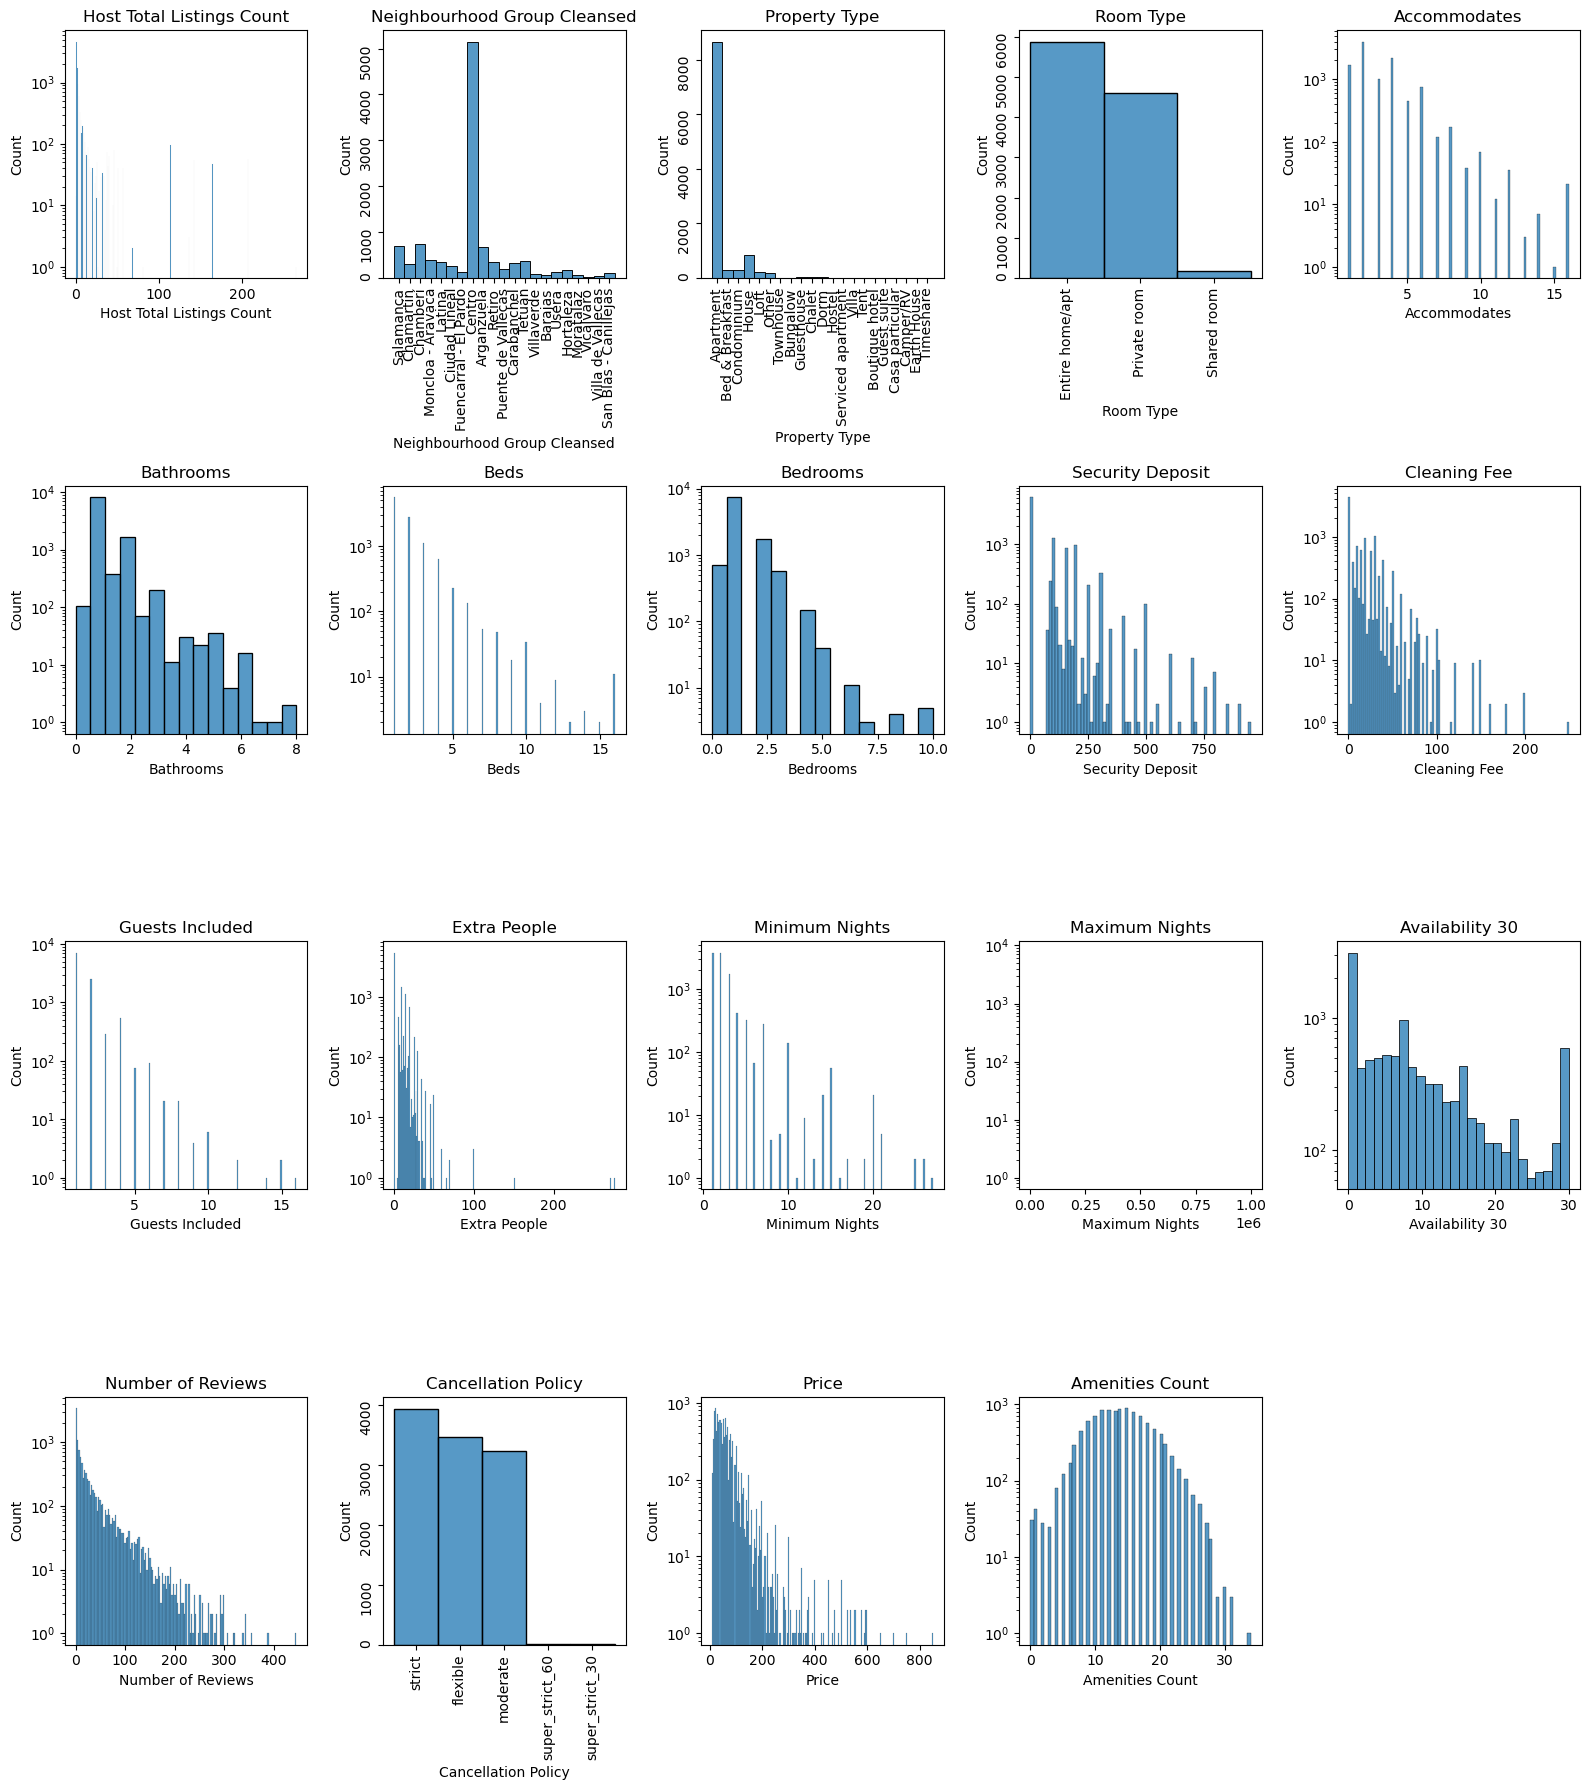

In [33]:
import math

df_plot = df_madrid.drop("Thumbnail Url", axis=1)
num_cols = len(df_plot.columns)
num_rows = math.ceil(num_cols / 5)

# Creo los subplots con los cálculos anteriores.
fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(16, num_rows * 4.5))

# Coloco los axes en fila para poderlos mover mejor.
axes = axes.flatten()

# Eliminamos las celdas que no tengan gráfica
for i in range(num_cols, num_rows * 5):
    fig.delaxes(axes[i])

# Loop para colocar secuencialmente las gráficas en sus subplots
for i, col in enumerate(df_plot.columns):
    # Creao un histograma para cada columna en el subplot correspondiente
    # Si es categórica, que ajuste el parámetro de hisplot() discrete=True
    
    if col in ["Neighbourhood Group Cleansed", "Property Type", "Room Type", "Cancellation Policy"]:
        # En las categóricas giraré las etiquetas
        sns.histplot(df_plot[col], ax=axes[i], discrete=True)
        axes[i].set_title(col)
        axes[i].tick_params(labelrotation=90)
    else:
        # Usaré una escala logarítmica en el eje y para resaltar los valores más pequeños
        sns.histplot(df_plot[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_yscale("log")
        
plt.tight_layout()
plt.show()

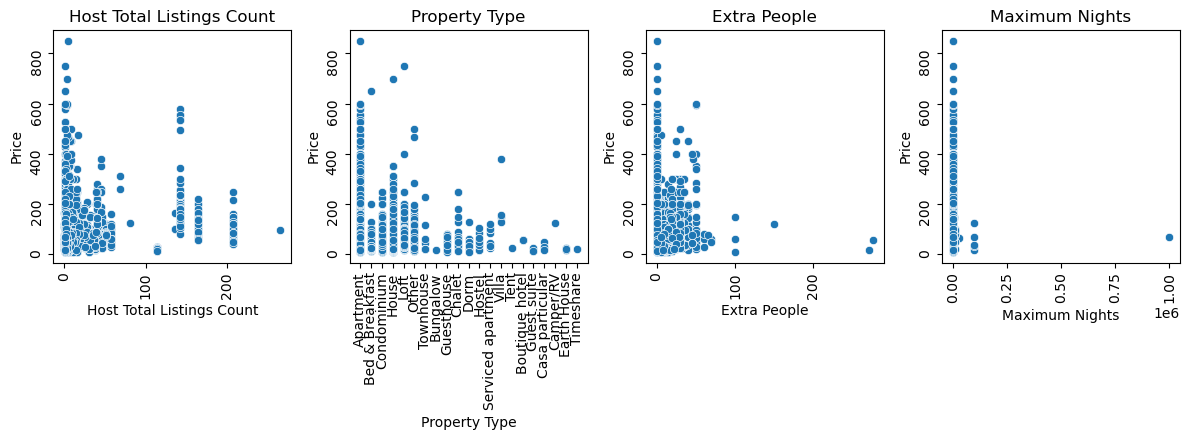

In [34]:
# Autoconfiguración de filas y columnas según el número de columnas del dataframe.
df_plot2 = df_madrid[["Host Total Listings Count", "Property Type", "Extra People", "Maximum Nights"]]
num_cols = len(df_plot2.columns)
num_rows = math.ceil(num_cols / 4) # Para calcular las filas dividimos por 4 columnas de ancho en cada fila, y redondeamos al más alto.

# Creo los subplots con los cálculos anteriores.
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, num_rows * 4.5))

# Coloco los axes en fila para poderlos mover mejor.
axes = axes.flatten()

# Eliminamos las celdas que no tengan gráfica
for i in range(num_cols, num_rows * 4):
    fig.delaxes(axes[i])

# Loop para colocar secuencialmente las gráficas en sus subplots
for i, col in enumerate(df_plot2.columns):
    # Creo un boxplot para cada columna en el subplot correspondiente
    sns.scatterplot(x=df_plot2[col], y=df_madrid["Price"], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

En casi todas las variables la distribución es right skewed, con valores distribuidos de manera continua, sin saltos grandes. Su continuidad indica que no son outliers.  
Sin embargo, en "Extra people" hay valores muy extremos muy separados de la distribución principal. Especialmente en "Maximum nights", hay valores tan extremos quye hace que el resto de la distribución no se vea. Vamos a tratar estos valores extremos.

#### Outliers:

* Analizamos "Extra People":

In [35]:
df_madrid["Extra People"].describe()

count    10649.000000
mean         7.163677
std          9.786382
min          0.000000
25%          0.000000
50%          0.000000
75%         13.000000
max        276.000000
Name: Extra People, dtype: float64

In [36]:
np.percentile(df_madrid["Extra People"],95)

24.0

In [37]:
# Veamos los 30 valores más altos
df_madrid[df_madrid["Extra People"] > 25].sort_values(by="Extra People")["Extra People"].tail(30)

305       50
6976      50
11450     50
8057      50
10561     50
2897      50
10988     50
2658      50
7735      50
11263     50
8853      50
5064      50
9195      50
12090     50
1871      50
8710      50
8748      50
1900      50
3603      60
6332      60
12981     60
7208      65
1669      70
13545     70
8327     100
8054     100
6725     100
5963     150
10888    271
4617     276
Name: Extra People, dtype: int64

En este caso se aprecian saltos muy grandes poco consecutivos al final de los datos ordenados. Sin embargo, siguen una cierta continuidad, y podrían ser valores verdaderos relacionados con hoteles u hostales. por los que lo conservaré.

* Ahora veremos "Maximum Nights":

In [38]:
df_madrid["Maximum Nights"].describe()

count      10649.000000
mean         983.006949
std         9937.468119
min            1.000000
25%          360.000000
50%         1125.000000
75%         1125.000000
max      1000000.000000
Name: Maximum Nights, dtype: float64

In [39]:
np.percentile(df_madrid["Maximum Nights"],95)

1125.0

In [40]:
# Veamos los 20 valores más altos
df_madrid[df_madrid["Maximum Nights"] > 25].sort_values(by="Maximum Nights")["Maximum Nights"].tail(24)

3046        2000
7062        2000
6139        2000
11089       2000
8876        5000
5316        5555
4211        9999
10895       9999
3713        9999
3989       10000
6757       10000
4226       10000
12369      10000
4169       10000
2445       10000
8549       11111
11776      11111
929        30000
3839       99999
4205       99999
7864       99999
5932       99999
5901      100000
1723     1000000
Name: Maximum Nights, dtype: int64

Teniendo en cuenta que el 95% de los valores están por debajo de 1125, lo cual indica que no hay un mínimo de noches de alquiler, no parece razonable conservar valores más altos que 5000. Todos los que estén más allé de 5000 se transformarán a 5000. Dado que es un valor de conversión fijo y establecido de antemano, se puede hacer antes del split, ya que no es un valor calculado en base a sumatorias del resto de los valores y no influirá en el entrenamiento.

In [41]:
df_madrid.loc[df_madrid["Maximum Nights"] > 5000, "Maximum Nights"] = 5000

In [42]:
df_madrid[df_madrid["Maximum Nights"] > 25].sort_values(by="Maximum Nights")["Maximum Nights"].tail(30)

8080     1825
8271     1825
2758     1900
7572     1999
12209    2000
6139     2000
11089    2000
7062     2000
2701     2000
3046     2000
11776    5000
12369    5000
4205     5000
4169     5000
4211     5000
4226     5000
5316     5000
1723     5000
8876     5000
3989     5000
929      5000
8549     5000
6757     5000
7864     5000
5901     5000
10895    5000
2445     5000
3839     5000
3713     5000
5932     5000
Name: Maximum Nights, dtype: int64

Volvamos a revisar el dataframe para continuar codificando las categóticas:

In [43]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10649 entries, 1 to 13999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Thumbnail Url                 10649 non-null  object 
 1   Host Total Listings Count     10649 non-null  float64
 2   Neighbourhood Group Cleansed  10649 non-null  object 
 3   Property Type                 10649 non-null  object 
 4   Room Type                     10649 non-null  object 
 5   Accommodates                  10649 non-null  int64  
 6   Bathrooms                     10649 non-null  float64
 7   Beds                          10649 non-null  float64
 8   Bedrooms                      10649 non-null  float64
 9   Security Deposit              10649 non-null  float64
 10  Cleaning Fee                  10649 non-null  float64
 11  Guests Included               10649 non-null  int64  
 12  Extra People                  10649 non-null  int64  
 13  Minimu

Tenemos varias features que son categóricas. Veamos qué se puede categorizar antes del split:  

In [44]:
df_madrid["Neighbourhood Group Cleansed"].unique()

array(['Salamanca', 'Chamartín', 'Chamberí', 'Moncloa - Aravaca',
       'Latina', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Centro',
       'Arganzuela', 'Retiro', 'Puente de Vallecas', 'Carabanchel',
       'Tetuán', 'Villaverde', 'Barajas', 'Usera', 'Hortaleza',
       'Moratalaz', 'Vicálvaro', 'Villa de Vallecas',
       'San Blas - Canillejas'], dtype=object)

In [45]:
df_madrid["Neighbourhood Group Cleansed"].nunique()

21

In [46]:
df_madrid["Property Type"].unique()

array(['Apartment', 'Bed & Breakfast', 'Condominium', 'House', 'Loft',
       'Other', 'Townhouse', 'Bungalow', 'Guesthouse', 'Chalet', 'Dorm',
       'Hostel', 'Serviced apartment', 'Villa', 'Tent', 'Boutique hotel',
       'Guest suite', 'Casa particular', 'Camper/RV', 'Earth House',
       'Timeshare'], dtype=object)

In [47]:
df_madrid["Property Type"].nunique()

21

In [48]:
df_madrid["Room Type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [49]:
df_madrid["Cancellation Policy"].unique()

array(['strict', 'flexible', 'moderate', 'super_strict_60',
       'super_strict_30'], dtype=object)

* Las dos variables de los barrios se pueden categorizar antes, ya que depende de su propio nombre, no de los valores de los demás registros.  
* Property Type y Room Type tienen categorías nominales que tampoco dependen de los valores de los demás registros.
* Cancellation Policy tampoco depende de los valores de las demás observaciones, así que se puede codificar antes del split.  
  

Todos los valores de las variables están predefinidas por AirBnb y no dependen de mediciones, razón añadida para poderlas codificar antes del split.

* Ahora codificaré "Cancellation Policy" con un LabelEncoding Ordinal, porque esta variable sí que es se hace más restrictiva según sube su categoría, desde un nivel 0 "Flexible" hasta un nivel 4 super estricto 60 días. Además, casualmente los nombres de las categorías ya están ordenados alfabéticamente de menos rígido a más rígido.

In [50]:
# Codificaré con sklearn, ya que tensorflow no permite como entradas strings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le_canc = LabelEncoder()
df_madrid["Cancellation Policy"] = le_canc.fit_transform(df_madrid["Cancellation Policy"])
# Veamos las categorías creadas y su correspondencia
listado_canc = [(idx,clase) for idx, clase in enumerate(le_canc.classes_)]
listado_canc

[(0, 'flexible'),
 (1, 'moderate'),
 (2, 'strict'),
 (3, 'super_strict_30'),
 (4, 'super_strict_60')]

In [51]:
df_madrid["Cancellation Policy"].head()

1    2
2    0
4    0
5    0
6    2
Name: Cancellation Policy, dtype: int64

In [52]:
df_madrid.describe()

,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Cancellation Policy,Price,Amenities Count
count,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000,10649.000000
mean,8.691145,3.075688,1.252841,1.936238,1.275988,74.212414,16.135506,1.553197,7.163677,2.410367,837.193258,8.403794,25.478636,1.045075,61.429524,13.937741
std,24.786946,1.965972,0.603838,1.495978,0.802178,110.366167,20.238648,1.076616,9.786382,2.209719,508.131887,8.694680,40.557337,0.834342,51.927425,4.740760
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,360.000000,0.000000,1.000000,0.000000,30.000000,11.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,10.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,9.000000,1.000000,50.000000,14.000000
75%,5.000000,4.000000,1.000000,2.000000,1.000000,150.000000,25.000000,2.000000,13.000000,3.000000,1125.000000,13.000000,32.000000,2.000000,75.000000,17.000000
max,265.000000,16.000000,8.000000,16.000000,10.000000,950.000000,250.000000,16.000000,276.000000,27.000000,5000.000000,30.000000,446.000000,4.000000,850.000000,34.000000


* Ahora, las demás variables usando get_dummies:

In [53]:
df_madrid = pd.get_dummies(df_madrid, columns=["Room Type", "Property Type", "Neighbourhood Group Cleansed"], dtype=int)
df_madrid

,Thumbnail Url,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,...,Neighbourhood Group Cleansed_Moratalaz,Neighbourhood Group Cleansed_Puente de Vallecas,Neighbourhood Group Cleansed_Retiro,Neighbourhood Group Cleansed_Salamanca,Neighbourhood Group Cleansed_San Blas - Canillejas,Neighbourhood Group Cleansed_Tetuán,Neighbourhood Group Cleansed_Usera,Neighbourhood Group Cleansed_Vicálvaro,Neighbourhood Group Cleansed_Villa de Vallecas,Neighbourhood Group Cleansed_Villaverde
1,https://a0.muscache.com/im/pictures/c4bd0aec-3...,164.0,7,2.0,5.0,2.0,100.0,60.0,1,5,...,0,0,0,1,0,0,0,0,0,0
2,https://a0.muscache.com/im/pictures/cba43537-1...,2.0,3,1.0,2.0,2.0,0.0,20.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,https://a0.muscache.com/im/pictures/43e5e3ce-d...,1.0,1,1.0,1.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,https://a0.muscache.com/im/pictures/74093962/e...,1.0,2,1.5,1.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,https://a0.muscache.com/im/pictures/27506c35-a...,1.0,6,1.0,3.0,2.0,120.0,25.0,2,12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,https://a0.muscache.com/im/pictures/6f12be9a-7...,1.0,1,1.0,1.0,1.0,0.0,10.0,1,22,...,0,0,0,0,0,0,0,0,0,0
13996,https://a0.muscache.com/im/pictures/eb603048-c...,1.0,4,1.0,1.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
13997,https://a0.muscache.com/im/pictures/11270498/b...,2.0,6,1.0,3.0,2.0,0.0,50.0,2,10,...,0,0,0,0,0,0,0,0,0,0
13998,https://a0.muscache.com/im/pictures/0e8bb248-5...,1.0,3,1.0,1.0,1.0,150.0,24.0,2,5,...,0,0,0,0,0,0,0,0,0,0


Sólo queda transformar todas las variables al mismo tipo de datos.  
Para ello vamos a inspeccionar primero los rangos de valores existentes antes de hacer el get_dummies (un chunk por encima de este), nos ayudará a reducir los bits del dtype:

* Podemos apreciar valores extremos de hasta 1 millón en la variable máximas noches, lo cual nos obliga a usar una alta profundidad de bits. Evidentemente, esto es un outlier, que trataremos después. Tras reducir outliers, puede que podamos optimizar el tipo de datos.

In [54]:
df_madrid[df_madrid.columns.difference(["Thumbnail Url"])] = df_madrid[df_madrid.columns.difference(["Thumbnail Url"])].astype("float32")
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10649 entries, 1 to 13999
Data columns (total 62 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Thumbnail Url                                       10649 non-null  object 
 1   Host Total Listings Count                           10649 non-null  float32
 2   Accommodates                                        10649 non-null  float32
 3   Bathrooms                                           10649 non-null  float32
 4   Beds                                                10649 non-null  float32
 5   Bedrooms                                            10649 non-null  float32
 6   Security Deposit                                    10649 non-null  float32
 7   Cleaning Fee                                        10649 non-null  float32
 8   Guests Included                                     10649 non-null  float32
 9   

Ya son del mismo tipo todas las variables, float32.

#### Preproc terminado.

---

<h2 align=center>ETAPA 2: EXTRACCIÓN DE IMÁGENES</h2>

El proceso de extraer las imágenes que podamos conseguir para el modelo convolucional podría producir muchos fallos derivados de la indexación cruzada entre los datasets tabulares y los de imágenes.  

* Primero bajaré todas las imágenes que pueda conseguir del dataset que ha quedado tras el filtrado como un solo archivo, guardando los índices del tabular que se han podido recuperar.
* Segundo, filtraremos el dataset tabular según los índices de las filas que han conseguido una imagen.  
* Tercero, guardaremos ambos archivos para poder reusar los datos y no tenerlos que descargar de nuevo. El proceso de guardar el tabular como csv y las imágenes en un array de numpy guardará en el minsmo orden los datos, y reseteará los índices usados anteriormente, creándolos de nuevo desde 0 a len(datos), de tal manera que se seguirán correspondiendo correctamente los datos entre los dos archivos.
* Cuarto, cargaremos los nuevos datos sustituyendo las variables que los guardaban anteriormente para optimizar la memoria.
* Quinto, el dataset tabular se dividirá en train, val y test primero. Los datos en cada división tendrán sus propios índices únicos.
* Sexto, crearé los splits de las imágenes usando los índices seleccionados en el split del tabular.

Empezaremos creando la función de decscarga de imágenes.

In [55]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

Cargamos en dos variables tanto las imágenes como los índices del tabular para los que se han encontrado estas imágenes, para todas las observaciones posibles del dataset, y comprobamos que se pueden leer:

100%|█████████████████████████████████████| 10649/10649 [56:38<00:00,  3.13it/s]


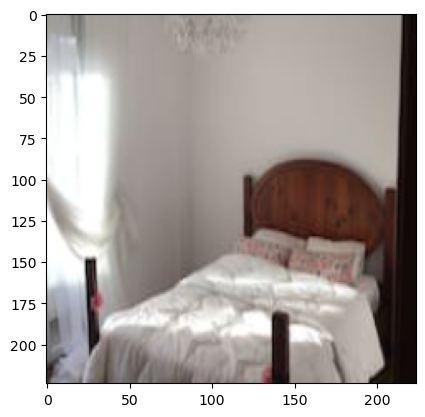

In [56]:
images_raw, idxs = download_images(df_madrid['Thumbnail Url'])
plt.imshow(images_raw[1])


  
Escalamos los valores de los píxeles de las imágenes con una técnica de Max Scaler, sobre el valor máximo que pueden tomar los píxeles. Son de una profundidad de 8 bits de color, por lo tanto 256 valores posibles:

In [57]:
images = images_raw.astype("float32") / 255.
images.shape

(8299, 224, 224, 3)

Ahora nos quedamos del tabular sólo las filas cuyos índices coinciden con los de las imágenes encontradas:

In [58]:
filtered_df = df_madrid.iloc[idxs]
filtered_df

,Thumbnail Url,Host Total Listings Count,Accommodates,Bathrooms,Beds,Bedrooms,Security Deposit,Cleaning Fee,Guests Included,Extra People,...,Neighbourhood Group Cleansed_Moratalaz,Neighbourhood Group Cleansed_Puente de Vallecas,Neighbourhood Group Cleansed_Retiro,Neighbourhood Group Cleansed_Salamanca,Neighbourhood Group Cleansed_San Blas - Canillejas,Neighbourhood Group Cleansed_Tetuán,Neighbourhood Group Cleansed_Usera,Neighbourhood Group Cleansed_Vicálvaro,Neighbourhood Group Cleansed_Villa de Vallecas,Neighbourhood Group Cleansed_Villaverde
1,https://a0.muscache.com/im/pictures/c4bd0aec-3...,164.0,7.0,2.0,5.0,2.0,100.0,60.0,1.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,https://a0.muscache.com/im/pictures/cba43537-1...,2.0,3.0,1.0,2.0,2.0,0.0,20.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://a0.muscache.com/im/pictures/43e5e3ce-d...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,https://a0.muscache.com/im/pictures/74093962/e...,1.0,2.0,1.5,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,https://a0.muscache.com/im/pictures/27506c35-a...,1.0,6.0,1.0,3.0,2.0,120.0,25.0,2.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13993,https://a0.muscache.com/im/pictures/105195120/...,11.0,8.0,2.0,4.0,2.0,0.0,39.0,4.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13996,https://a0.muscache.com/im/pictures/eb603048-c...,1.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13997,https://a0.muscache.com/im/pictures/11270498/b...,2.0,6.0,1.0,3.0,2.0,0.0,50.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13998,https://a0.muscache.com/im/pictures/0e8bb248-5...,1.0,3.0,1.0,1.0,1.0,150.0,24.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Guardamos en el disco un array de numpy que contiene las imágenes, y en un .csv el dataset resultante del filtrado. Este proceso resetea los índices de ambos archivos, que empiezan de nuevo de 0 los dos, quedando sincronizadas las imágenes con su observación nuevamente:

In [59]:
np.save('images.npy', images)
filtered_df.to_csv('filtered_data.csv', sep=';', index=False)

---

<h2 align=center>ETAPA 3: SPLIT DE DATOS Y FINALIZACIÓN EN ARRAYS</h2>

Cargamos los ficheros para comprobar su tamaño y los usamos a partir de ahora para el flujo de trabajo. A partir de aquí esto podría comenzar un notebook diferente, con procesos separados para la ingesta de datos y para el modelado.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import InceptionV3, Xception, VGG16, VGG19, ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import callbacks, regularizers
from tensorflow.keras import optimizers, Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import cv2
import imageio.v3 as io
from tqdm import tqdm

# Para hacerlo reproducible
np.random.seed(42)

In [3]:
# Comprobamos a abrirlos de nuevo
saved_data = pd.read_csv("filtered_data.csv", sep=';')
images = np.load("images.npy")
saved_data.shape, images.shape

((8299, 62), (8299, 224, 224, 3))

En primer lugar, separaremos la variable target de las features:

In [4]:
feats = saved_data.drop("Price", axis=1)
y = saved_data.Price
print(feats.shape)
print(y.shape)

(8299, 61)
(8299,)


En un primer split, separamos los datos de test del resto:

In [5]:
X_raw, X_test, y_raw, y_test, images_raw, ims_test = train_test_split(feats, y, images, test_size=0.25, random_state=42)
print(X_raw.shape, X_test.shape, y_raw.shape, y_test.shape, images_raw.shape, ims_test.shape)

(6224, 61) (2075, 61) (6224,) (2075,) (6224, 224, 224, 3) (2075, 224, 224, 3)


En un segundo split, los datos restantes del anterior los volvemos a dividir, esta vez ya en train y validation:

In [6]:
X_train, X_val, y_train, y_val, ims_train, ims_val = train_test_split(X_raw, y_raw, images_raw, test_size=0.15, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape, ims_train.shape, ims_val.shape)

(5290, 61) (934, 61) (5290,) (934,) (5290, 224, 224, 3) (934, 224, 224, 3)


Ahora dividimos el array de imágenes usando los índices de los splits

Para comprobar que el proceso se ha realizado bien, cotejaré la imagen online de cualquier observación, usando su campo url, con la imagen presente en el array de Numpy.  
Crearé dos funciones encadenadas para pedirle al usuario su elección de comparación. 

In [7]:
#  Compararemos ambas imágenes con una función que he preparado:
def check1():
    while True:
        opcion = input("Por favor, introduce el split a testear: 0 para Train, 1 para Test, 2 para Validation: ")
        if opcion in ['0', '1', '2']:
            opcion = int(opcion)
            if opcion == 0:
                return X_train, ims_train
            elif opcion == 1:
                return X_test, ims_test
            elif opcion == 2:
                return X_val, ims_val
        else:
            print("Valor incorrecto, vuelve a intentarlo.")

def comparar():
    split, ims_split = check1()
    while True:
        resp = int(input(f"\nIntroduce un índice integer cualquiera hasta el {split.shape[0]} : "))
        if 0 <= resp <= split.shape[0]:
            print("\n·HAZ CLICK en el siguiente enlace y compara el resultado de la web con la imagen que aparece abajo:\n")
            return split.iloc[resp][0], plt.imshow(ims_split[resp])
        else:
            print("Valor no válido. Por favor, introduce un valor válido.")

Ejecutamos la función frontend para la comparación:

Por favor, introduce el split a testear: 0 para Train, 1 para Test, 2 para Validation:  1

Introduce un índice integer cualquiera hasta el 2075 :  1111



·HAZ CLICK en el siguiente enlace y compara el resultado de la web con la imagen que aparece abajo:



('https://a0.muscache.com/im/pictures/14467920-873b-4913-b8ab-ff517e8a88f9.jpg?aki_policy=small',
 <matplotlib.image.AxesImage at 0x2adf81890>)

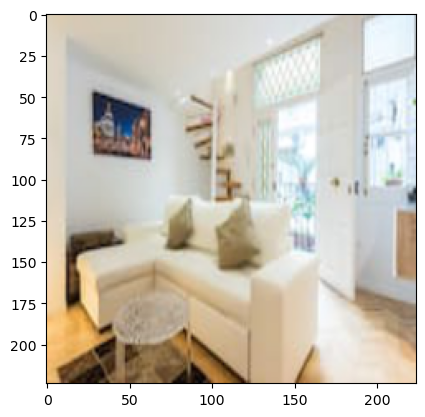

In [8]:
comparar()

Tras esto, sólo queda eliminar la variable de las imágenes del dataframe:

In [9]:
X_train = X_train.drop(["Thumbnail Url"], axis=1)
X_test = X_test.drop(["Thumbnail Url"], axis=1)
X_val = X_val.drop(["Thumbnail Url"], axis=1)

Por último, los 6 splits a arrays de Numpy:

In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

---

<h2 align=center>ETAPA 4: MODELADO DE LA RED PARA LAS IMÁGENES</h2>

Vamos a escalar los arrays tabulares:

In [11]:
scalerX = MinMaxScaler(feature_range=(0, 1)).fit(X_train)

X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)
X_val_scaled = scalerX.transform(X_val)

scalerY = MinMaxScaler().fit(y_train)

y_train_scaled = scalerY.transform(y_train)
y_test_scaled = scalerY.transform(y_test)
y_val_scaled = scalerY.transform(y_val)

Comprobamos resultados del escalado y la inversa del escalado:

In [12]:
y_val[1]

array([45.])

In [13]:
y_val_scaled[1]

array([0.04166667])

In [14]:
scalerY.inverse_transform(y_val_scaled)[1]

array([45.])

Ahora estandarizaré los splits tabulares, ya escalados todos:

In [ ]:
# Podemos hacerlo a mano:

"""# Para evitar errores arrojados por divisiones por valores que son 0 de las múltiples variables one-hot
np.seterr(divide='ignore', invalid='ignore')

# Encontramos la media y el sigma de tabulares
X_train_mean = np.mean(X_train_scaled, axis=0)
X_train_std = np.std(X_train_scaled, axis=0)

# Centramos tabulares
X_train_cent = X_train_scaled - X_train_mean
X_test_cent = X_test_scaled - X_train_mean
X_val_cent = X_val_scaled - X_train_mean

# Normalizamos tabulares:
X_train_norm = X_train_cent / X_train_std
X_test_norm = X_test_cent / X_train_std
X_val_norm = X_val_cent / X_train_std"""

In [ ]:
"""# Encontramos la media y el sigma del target
y_train_mean = np.mean(y_train_scaled, axis=0)
y_train_std = np.std(y_train_scaled, axis=0)

# Centramos
y_train_cent = y_train_scaled - y_train_mean
y_test_cent = y_test_scaled - y_train_mean
y_val_cent = y_val_scaled - y_train_mean

# Normalizamos
y_train_norm = y_train_cent / y_train_std
y_test_norm = y_test_cent / y_train_std
y_val_norm = y_val_cent / y_train_std"""

In [15]:
# ... o usar la función de sklearn:

standarizerX = StandardScaler().fit(X_train_scaled)

X_train_stand = standarizerX.transform(X_train_scaled)
X_test_stand = standarizerX.transform(X_test_scaled)
X_val_stand = standarizerX.transform(X_val_scaled)

standarizerY = StandardScaler().fit(y_train_scaled)

y_train_stand = standarizerY.transform(y_train_scaled)
y_test_stand = standarizerY.transform(y_test_scaled)
y_val_stand = standarizerY.transform(y_val_scaled)

Hacemos una prueba de normalización completa y su inversa para comprobar resultados:

In [16]:
y_train[:5]

array([[36.],
       [18.],
       [28.],
       [50.],
       [45.]])

In [17]:
y_train_scaled[:5]

array([[0.03095238],
       [0.00952381],
       [0.02142857],
       [0.04761905],
       [0.04166667]])

In [18]:
y_train_stand[:5]

array([[-0.49088643],
       [-0.83301939],
       [-0.64294552],
       [-0.22478301],
       [-0.31981994]])

In [19]:
tur = standarizerY.inverse_transform(y_train_stand)[:5]
tur

array([[0.03095238],
       [0.00952381],
       [0.02142857],
       [0.04761905],
       [0.04166667]])

In [20]:
scalerY.inverse_transform(tur)

array([[36.],
       [18.],
       [28.],
       [50.],
       [45.]])

<h2 align=center>Modelo manual</h2>

Comenzaré por un modelo manual usando capas añadidas manualmente.

In [21]:
# Usaremos el esquema secuencial
model_ima = Sequential()

# Definimos parámetros
do = 0.2

# Primera capa convolucional de INPUT
model_ima.add(Conv2D(128, kernel_size=(3,3), activation="relu", input_shape=(224,224,3)))

# Añadimos optimizaciones de normalización por batch, Pooling con el máximo valor de 2x2, y un dropout
model_ima.add(MaxPooling2D(pool_size=(2, 2)))
model_ima.add(BatchNormalization())
model_ima.add(Dropout(do))

# Añadimos segunda capa convolucional
model_ima.add(Conv2D(256, kernel_size=(3,3), activation="relu"))
model_ima.add(MaxPooling2D(pool_size=(2, 2)))
model_ima.add(BatchNormalization())
model_ima.add(Dropout(do))

# Añadimos segunda capa convolucional
model_ima.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model_ima.add(MaxPooling2D(pool_size=(2, 2)))
model_ima.add(BatchNormalization())
model_ima.add(Dropout(do))
              
# Hacemos un flatten para preparar la salida a capa densa
model_ima.add(Flatten())

# Capas densas:
model_ima.add(Dense(128, activation='relu'))
model_ima.add(Dense(64, activation='relu'))
model_ima.add(Dropout(do))

# Capa densa de salida de regresión
model_ima.add(Dense(1, activation="sigmoid"))

model_ima.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 128)     512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 111, 111, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 256)       0

2024-03-03 23:32:29.494914: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-03 23:32:29.494949: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-03 23:32:29.494956: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-03 23:32:29.495010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-03 23:32:29.495044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total params: 11679873 (44.56 MB)
Trainable params: 11678849 (44.55 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


In [ ]:
# Definimos parámetros de compilación y entrenamiento
batch_size = 128
epochs = 50
lr = 5e-3
#decay = 1e-4 / 200

# Establecemos una semilla
np.random.seed(42)

# Compilamos el modelo
model_ima.compile(loss="mean_squared_error", optimizer=Adam(lr))

# Entrenamos el modelo
H_im = model_ima.fit(ims_train, y_train_stand, batch_size=batch_size, epochs=epochs, validation_data=(ims_val, y_val_stand))


Epoch 1/50


2024-03-03 23:32:37.148939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-03 23:32:37.186141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


42/42 [==============================] - 32s 720ms/step - loss: 1.2487 - val_loss: 1.9953
Epoch 2/50
42/42 [==============================] - 29s 696ms/step - loss: 1.2229 - val_loss: 1.9788
Epoch 3/50
42/42 [==============================] - 30s 704ms/step - loss: 1.1614 - val_loss: 1.9808
Epoch 4/50
42/42 [==============================] - 30s 710ms/step - loss: 1.2403 - val_loss: 1.1008
Epoch 5/50
42/42 [==============================] - 30s 717ms/step - loss: 1.3141 - val_loss: 1.2539
Epoch 6/50
42/42 [==============================] - 29s 695ms/step - loss: 1.2924 - val_loss: 1.2055
Epoch 7/50
42/42 [==============================] - 30s 704ms/step - loss: 1.2997 - val_loss: 1.0846
Epoch 8/50
42/42 [==============================] - 29s 696ms/step - loss: 1.1747 - val_loss: 1.0249
Epoch 9/50
42/42 [==============================] - 30s 719ms/step - loss: 1.1033 - val_loss: 1.2374
Epoch 10/50
42/42 [==============================] - 31s 743ms/step - loss: 1.3159 - val_loss: 1.3907


In [40]:
# Evaluamos con la métrica del modelo
train_mse_man = model_ima.evaluate(ims_train, y_train_stand)
val_mse_man = model_ima.evaluate(ims_val, y_val_stand)
test_mse_man = model_ima.evaluate(ims_test, y_test_stand)

print("Train Score:", train_mse_man)
print("Validation Score:", val_mse_man)
print("Test Score:", test_mse_man)

65/65 [==============================] - 2s 26ms/step - loss: 1.3360
Train Score: 1.3668004274368286
Validation Score: 1.3503026962280273
Test Score: 1.3360244035720825


In [37]:
train_mse_man

1.3668004274368286

In [34]:

# Predecimos sobre los 3 splits para evaluar el error en euros
train_preds_man0 = model_ima.predict(ims_train, batch_size=batch_size)
val_preds_man0 = model_ima.predict(ims_val, batch_size=batch_size)
test_preds_man0 = model_ima.predict(ims_test, batch_size=batch_size)

# Deshacemos la estandarización
train_preds_man1 = standarizerY.inverse_transform(train_preds_man0)
val_preds_man1 = standarizerY.inverse_transform(val_preds_man0)
test_preds_man1 = standarizerY.inverse_transform(test_preds_man0)

# Deshacemos el escalado
train_preds_man = scalerY.inverse_transform(train_preds_man1)
val_preds_man = scalerY.inverse_transform(val_preds_man1)
test_preds_man = scalerY.inverse_transform(test_preds_man1)

# Evaluación del modelo con la escala de error en euros
train_rmse_man = math.sqrt(mean_squared_error(y_train, train_preds_man))
print('Train Score: %.2f RMSE' % (train_rmse_man))
val_rmse_man = math.sqrt(mean_squared_error(y_val, val_preds_man))
print('Train Score: %.2f RMSE' % (val_rmse_man))
test_rmse_man = math.sqrt(mean_squared_error(y_test, test_preds_man))
print('Test Score: %.2f RMSE' % (test_rmse_man))


17/17 [==============================] - 1s 82ms/step
Train Score: 61.51 RMSE
Train Score: 61.14 RMSE
Test Score: 60.81 RMSE


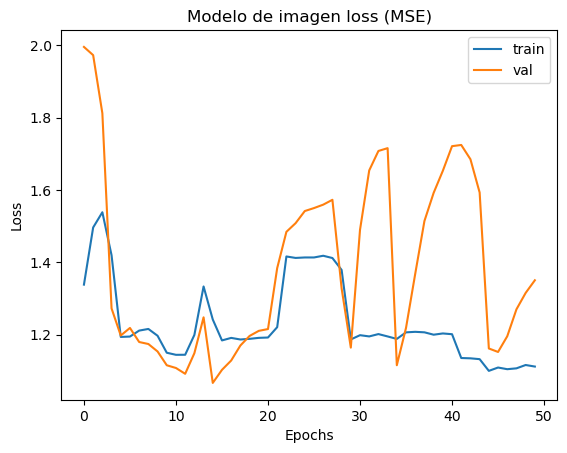

In [35]:
# Dibujamos las curvas de pérdidas
plt.plot(H_im.history['loss'], label='train')
plt.plot(H_im.history['val_loss'], label='val')
plt.title('Modelo de imagen loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
train_preds_man.shape

(5290, 1)

In [27]:
train_preds_man

array([[61.826084],
       [61.826084],
       [61.826084],
       ...,
       [61.826084],
       [61.826084],
       [61.826084]], dtype=float32)

<h2 align=center>Modelo preentrenado</h2>

Primero creamos el modelo base preentrenado con una red VGG16 y bajamos la red de pesos entrenados correspondiente al modelo

In [28]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Congelamos las capas y le añadimos nuestro regresor:

In [29]:
# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
for layer in base_model.layers:
    layer.trainable = False
    print('Capa ' + layer.name + ' congelada.')


# cogemos la última capa del model y le añadimos nuestro regresor (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(ims_train.shape[0], activation='relu', name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)
model_pre = Model(base_model.input, x)

# compilamos el modelo
model_pre.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mean_squared_error'])

# vemos la estructura del modelo
model_pre.summary()

Capa input_1 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64

Entrenamos:

In [1]:
epochs = 10
batch_size = 256

H_pre = model_pre.fit(ims_train, y_train_stand,
          batch_size=batch_size,
          validation_data=(ims_val, y_val_stand),
          epochs=epochs)

NameError: name 'model_pre' is not defined

Evaluamos con la métrica del modelo (MSE):

In [21]:
train_mse_pre = model_pre.evaluate(ims_train, y_train_stand)
val_mse_pre = model_pre.evaluate(ims_val, y_val_stand)
test_mse_pre = model_pre.evaluate(ims_test, y_test_stand)

print("Train Score:", train_mse_pre)
print("Validation Score:", val_mse_pre)
print("Test Score:", test_mse_pre)

65/65 [==============================] - 8s 116ms/step - loss: 0.9586 - mean_squared_error: 0.9586
Train Score: [0.999999463558197, 0.999999463558197]
Validation Score: [0.9736959338188171, 0.9736959338188171]
Test Score: [0.9586493968963623, 0.9586493968963623]


Ahora vamos a averiguar el error en las unidades reales del target (Euros) sobre los 3 splits:

In [23]:
# Predecimos sobre los 3 splits
train_preds_pre0 = model_pre.predict(ims_train, batch_size=batch_size)
val_preds_pre0 = model_pre.predict(ims_val, batch_size=batch_size)
test_preds_pre0 = model_pre.predict(ims_test, batch_size=batch_size)

# Deshacemos la estandarización
train_preds_pre1 = standarizerY.inverse_transform(train_preds_pre0)
val_preds_pre1 = standarizerY.inverse_transform(val_preds_pre0)
test_preds_pre1 = standarizerY.inverse_transform(test_preds_pre0)

# Deshacemos el escalado
train_preds_pre = scalerY.inverse_transform(train_preds_pre1)
val_preds_pre = scalerY.inverse_transform(val_preds_pre1)
test_preds_pre = scalerY.inverse_transform(test_preds_pre1)

# Evaluación del modelo con la escala original
train_rmse_pre = math.sqrt(mean_squared_error(y_train, train_preds_pre))
print('Train Score: %.2f RMSE' % (train_rmse_pre))
val_rmse_pre = math.sqrt(mean_squared_error(y_val, val_preds_pre))
print('Train Score: %.2f RMSE' % (val_rmse_pre))
test_rmse_pre = math.sqrt(mean_squared_error(y_test, test_preds_pre))
print('Test Score: %.2f RMSE' % (test_rmse_pre))

9/9 [==============================] - 7s 810ms/step
Train Score: 52.61 RMSE
Train Score: 51.91 RMSE
Test Score: 51.51 RMSE


Dibujamos la pérdida en MSE

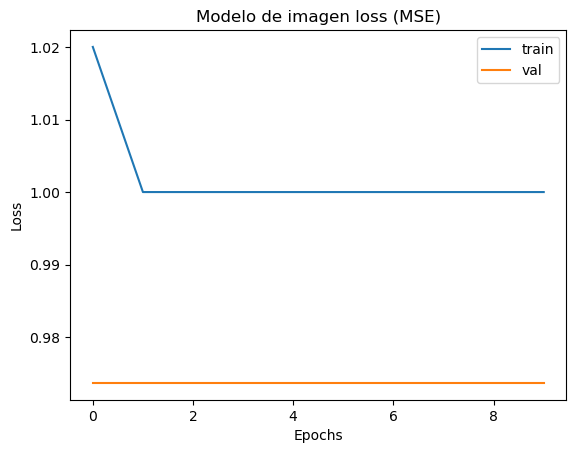

In [24]:

plt.plot(H_pre.history['loss'], label='train')
plt.plot(H_pre.history['val_loss'], label='val')
plt.title('Modelo de imagen loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Ahora vamos a hacer fine-tunning en la última capa convolucional:

In [25]:
# Bloqueamos todas menos la última capa convolucional
for layer in base_model.layers:
    layer.trainable = False
    if layer.name == "block5_conv4":
        layer.trainable = True
        print('Capa ' + layer.name + ' habilitada.')    
    else:
        print('Capa ' + layer.name + ' congelada.')

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(ims_train.shape[0], activation='relu', name='fc1')(x)
x = Dropout(0.35)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)
model_tun = Model(base_model.input, x)

# compilamos el modelo
model_tun.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mean_squared_error'])

# vemos la estructura del modelo
model_tun.summary()

Capa input_1 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 

Entrenamos:

In [26]:
epochs = 10
batch_size = 128

# como entrenariamos normalmente
H_tun = model_tun.fit(ims_train, y_train_stand,
          batch_size=batch_size,
          validation_data=(ims_val, y_val_stand),
          epochs=epochs)

Epoch 1/10


2024-03-03 15:50:57.222571: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


42/42 [==============================] - 21s 482ms/step - loss: 1.0011 - mean_squared_error: 1.0011 - val_loss: 0.9737 - val_mean_squared_error: 0.9737
Epoch 2/10
42/42 [==============================] - 20s 474ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 0.9737 - val_mean_squared_error: 0.9737
Epoch 3/10
42/42 [==============================] - 20s 472ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 0.9737 - val_mean_squared_error: 0.9737
Epoch 4/10
42/42 [==============================] - 20s 471ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 0.9737 - val_mean_squared_error: 0.9737
Epoch 5/10
42/42 [==============================] - 20s 471ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 0.9737 - val_mean_squared_error: 0.9737
Epoch 6/10
42/42 [==============================] - 21s 493ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 0.9737 - val_mean_squared_error: 0.9737
Epoch 7/10
42/42 [===============

De nuevo, predecimos y calculamos el error sobre las unidades reales del target:

In [27]:
# Predecimos sobre los 3 splits
train_preds_tun0 = model_pre.predict(ims_train, batch_size=batch_size)
val_preds_tun0 = model_pre.predict(ims_val, batch_size=batch_size)
test_preds_tun0 = model_pre.predict(ims_test, batch_size=batch_size)

# Deshacemos la estandarización
train_preds_tun1 = standarizerY.inverse_transform(train_preds_tun0)
val_preds_tun1 = standarizerY.inverse_transform(val_preds_tun0)
test_preds_tun1 = standarizerY.inverse_transform(test_preds_tun0)

# Deshacemos el escalado
train_preds_tun = scalerY.inverse_transform(train_preds_tun1)
val_preds_tun = scalerY.inverse_transform(val_preds_tun1)
test_preds_tun = scalerY.inverse_transform(test_preds_tun1)

# Evaluación del modelo con la escala original
train_rmse_tun = math.sqrt(mean_squared_error(y_train, train_preds_tun))
print('Train Score: %.2f RMSE' % (train_rmse_tun))
val_rmse_tun = math.sqrt(mean_squared_error(y_val, val_preds_tun))
print('Train Score: %.2f RMSE' % (val_rmse_tun))
test_rmse_tun = math.sqrt(mean_squared_error(y_test, test_preds_tun))
print('Test Score: %.2f RMSE' % (test_rmse_tun))

17/17 [==============================] - 6s 396ms/step
Train Score: 52.61 RMSE
Train Score: 51.91 RMSE
Test Score: 51.51 RMSE


Dibujamos la curva de pérdidas en MSE:

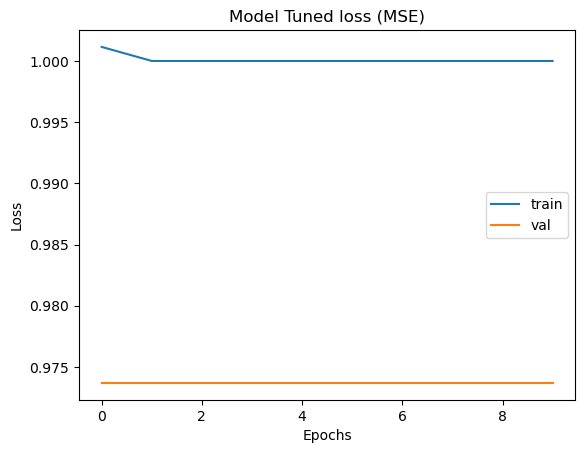

In [28]:
plt.plot(H_tun.history['loss'], label='train')
plt.plot(H_tun.history['val_loss'], label='val')
plt.title('Model Tuned loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

<h2 align=center>ETAPA 5: MODELADO DE LA RED PARA TABULARES</h2>

In [ ]:

# Definimos parámetros
do = 0.13

# Crear el modelo
model_tab = Sequential()

# Capa de entrada
n_cols = X_train.shape[1]
model_tab.add(Dense(n_cols, activation='relu', input_shape=(n_cols,)))
model_tab.add(BatchNormalization())
model_tab.add(Dropout(do))

# Capas ocultas
model_tab.add(Dense(256, activation='relu'))
model_tab.add(BatchNormalization())
model_tab.add(Dropout(do))

model_tab.add(Dense(512, activation='relu'))
model_tab.add(BatchNormalization())
model_tab.add(Dropout(do))

model_tab.add(Dense(256, activation='relu'))
model_tab.add(BatchNormalization())
model_tab.add(Dropout(do))

model_tab.add(Dense(n_cols, activation='relu'))
model_tab.add(BatchNormalization())
model_tab.add(Dropout(do))

# Capa de salida
model_tab.add(Dense(1, activation='sigmoid'))

model_tab.summary()

In [ ]:
# Definimos parámetros de compilación y entrenamiento
batch_size = 128

#batches_train = np.ceil(X_train_norm.shape[0]/batch_size)
#batches_test = np.ceil(X_test_norm.shape[0]/batch_size)
#batches_val = np.ceil(X_al_norm.shape[0]/batch_size)
epochs = 100
lr = 5e-3
decay = 1e-4 / 200

# Compilamos el modelo
model_tab.compile(loss="mean_squared_error", optimizer=SGD(lr), metrics=["mean_squared_error"])

np.random.seed(42)

# Entrenamos el modelo
H_tab = model_tab.fit(X_train_scaled, y_train_scaled, batch_size=batch_size, shuffle=True, epochs=epochs, validation_data=(X_val_scaled, y_val_scaled))

# Predecimos
train_preds_tab = model_tab.predict(X_train_scaled)
val_preds_tab = model_tab.predict(X_val_scaled)
test_preds_tab = model_tab.predict(X_test_scaled)

trainPredict_tab0 = standarizerY.inverse_transform(train_preds_tab)
valPredict_tab0 = standarizerY.inverse_transform(val_preds_tab)
testPredict_tab0 = standarizerY.inverse_transform(test_preds_tab)

trainPredictTab = scalerY.inverse_transform(trainPredict_tab0)
valPredictTab = scalerY.inverse_transform(valPredict_tab0)
testPredictTab = scalerY.inverse_transform(testPredict_tab0)

# Evaluación del modelo
trainScoreTab = math.sqrt(mean_squared_error(y_train_stand, trainPredictTab))
print('Train Score: %.2f RMSE' % (trainScoreTab))
valScoreTab = math.sqrt(mean_squared_error(y_val_stand, valPredictTab))
print('Train Score: %.2f RMSE' % (valScoreTab))
testScoreTab = math.sqrt(mean_squared_error(y_test_stand, testPredictTab))
print('Test Score: %.2f RMSE' % (testScoreTab))


"""train_score = model_tab.evaluate(ims_train, y_train_stand)
val_score = model_tab.evaluate(ims_val, y_val_stand)
test_score = model_tab.evaluate(ims_test, y_test_stand)

print("Train Score:", train_score)
print("Validation Score:", val_score)
print("Test Score:", test_score)"""

In [ ]:
plt.plot(H_tab.history['loss'], label='train')
plt.plot(H_tab.history['val_loss'], label='val')
plt.title('model_ima loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


---

<h2 align=center>ETAPA 6: FUSIÓN DE MODELOS</h2>

In [ ]:
test_preds_tun

In [ ]:
model_fus = Sequential()

model_fus.add(Dense())